# Melanoma Detection Using CNN

#### Created by: Raja Kalavala


## Contents
0. [Problem Statement](#problem-statement)
1. [Data Reading and Understanding](#data-reading-and-understanding)
2. [Dataset Creation](#data-creation)
3. [Visualise the Data](#visualise-the-data)
4. [Model Building & Training](#model-building-training)
5. [Data Augmentation](#data-augmentation)
6. [Model Building & Training on the Augmented Data](#model-building-ad)
7. [Class Distribution](#class-distribution)
8. [Handling Class Imbalances](#class-imbalance)
9. [Model Building and Training on Rectified Class Imbalance Data](#model-building-rcid)
10. [Final Conclusion](#final-conclusion)

## Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1. Data Reading & Understanding

### 1.1 Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
import keras_cv
from glob import glob

/Users/rajak/Workstation/Projects/myGitHub/LearnAIML/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Load Skin Care Data 

NOTE: 
* This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./Skin_Cancer_images/Train")
data_dir_test = pathlib.Path('./Skin_Cancer_images/Test')

In [8]:
# Understand the image count of train and test sets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 2. Dataset Creation

### 2.1. Import keras.preprocessing



In [9]:
# Let's load these images off disk using the helpful image_dataset_from_directory utility.

from tensorflow.keras.utils import load_img

### 2.2. Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Note - use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note - make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [12]:
## Note - use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note - make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualize the data

### 3.1. Plot Images

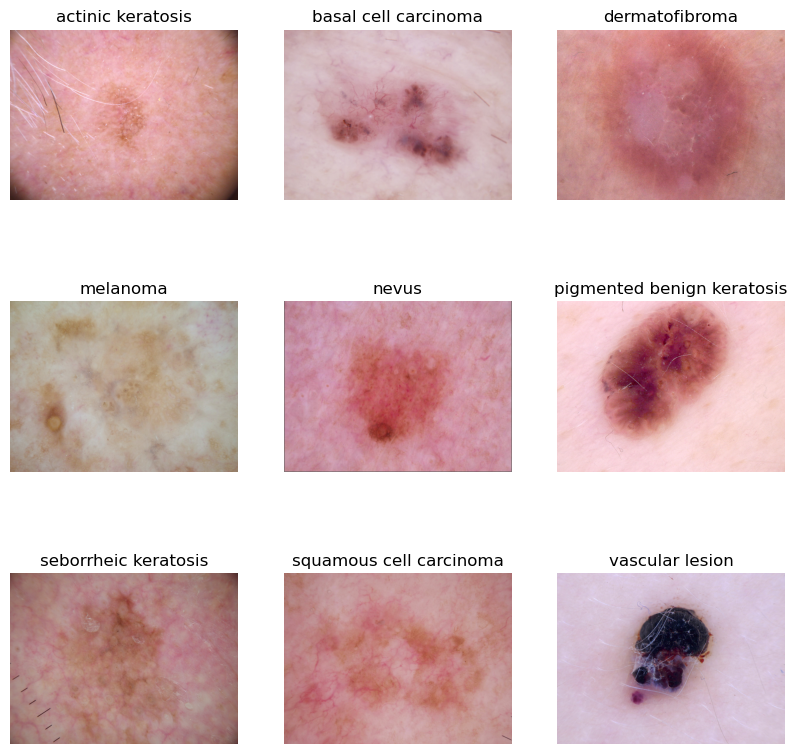

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")

NOTE: 

* The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.
* `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
* `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### 3.2. Configure the Dataset for performance

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building & Training

### 4.1. Create the model


Note: 
* Create a CNN model, which can accurately detect 9 classes present in the dataset. 
* Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. 
* This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/Users/rajak/Workstation/Projects/myGitHub/LearnAIML/env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Note - first layer (Rescaling(1./255) rescales the RGB channel values.

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

/Users/rajak/Workstation/Projects/myGitHub/LearnAIML/env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### 4.2 Compile the model


Note:
* Choose an appropirate optimiser and loss function for model training 

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,659,081 (6.33 MB)

 Trainable params: 1,659,081 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3. Train the model

In [20]:
epochs = 20
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.2404 - loss: 1.9794 - val_accuracy: 0.2609 - val_loss: 1.9501
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.4366 - loss: 1.4656 - val_accuracy: 0.3043 - val_loss: 3.1081
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.5276 - loss: 1.2651 - val_accuracy: 0.2609 - val_loss: 2.2536
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.6128 - loss: 1.0391 - val_accuracy: 0.3913 - val_loss: 2.5878
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.6634 - loss: 0.9073 - val_accuracy: 0.1739 - val_loss: 4.0643
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.7581 - loss: 0.6890 - val_accuracy: 0.2174 - val_loss: 2.7484
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8271 - loss: 0.5015 - val_accuracy: 0.2174 - val_loss: 5.0987
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8646 - loss: 0

### 4.4. Visualizing training results

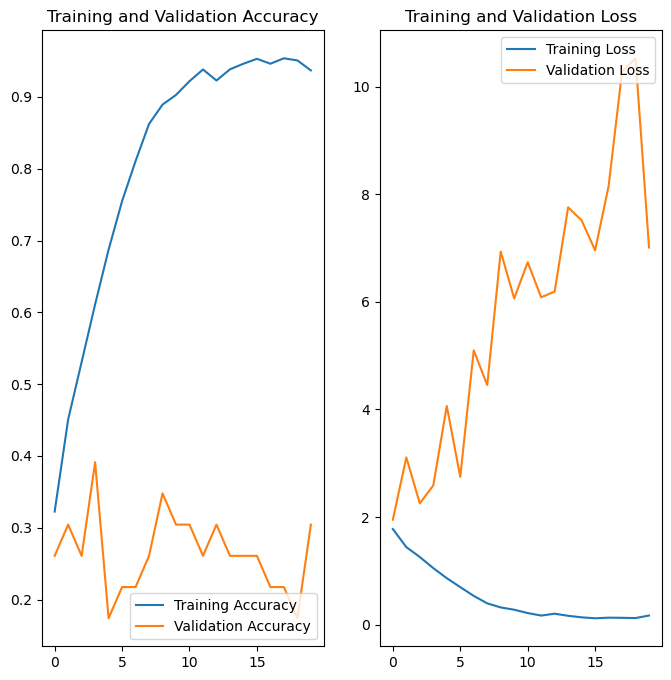

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
loss, accuracy = model.evaluate(cached_train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(cached_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9586 - loss: 0.1048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3043 - loss: 7.0109
Accuracy:  0.9582715034484863
Validation Accuracy:  0.30434781312942505
Loss:  0.10635901242494583
Validation Loss 7.01094388961792


<div class="alert alert-block alert-info">
<h3>OBSERVATIONS:</h3>

1. The Model's training accuracy shows around 87%, while validation accuracy remains around 26%. <br>
2. As observed in the graph, as training proceeds, while training loss decreases, validation loss increases.
3. There is clearly evidence of `Overfitting`, with the difference between training accuracy and validation accuracy being greater than 0.5

</div>

## 5. Data Augmentation

### 5.1. Creation of data augmentation layer architecture for reuse


In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

### 5.2. Visualisation of data augmentation showing 9 exemplars for a single image

2024-12-15 16:47:32.756101: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


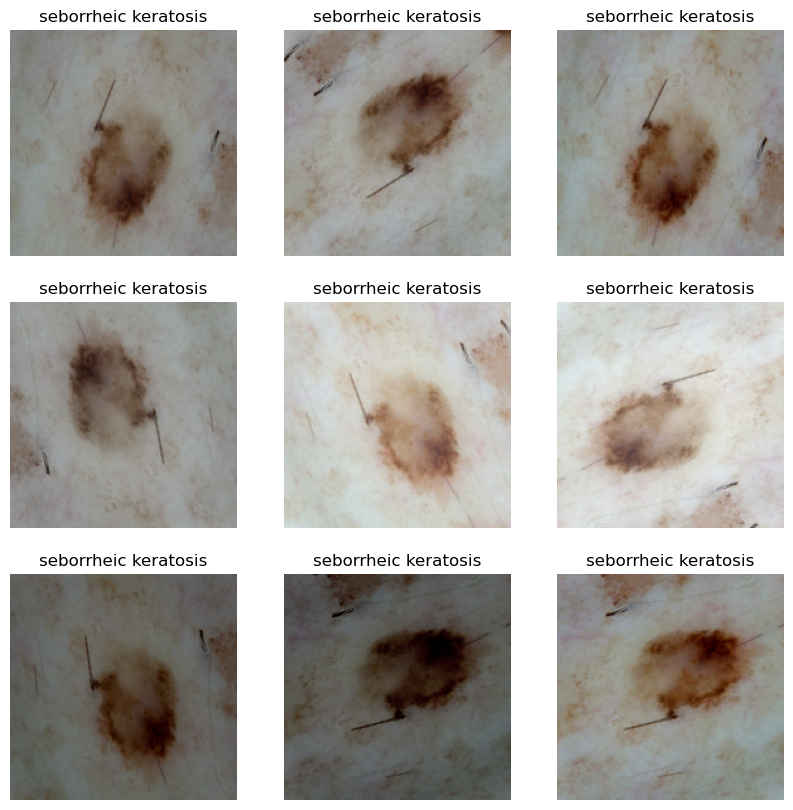

In [24]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

## 6. Model Building & Training on the Augmented Data

### 6.1 Model Creation with Augmentation and Dropout layers


In [25]:
# Modifying the following variables to experiment with dropout probabilities for different layer types
dropout_conv=0.05
dropout_dense=0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])


### 6.2. Compiling the model

In [26]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 6.3. Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.1366 - loss: 2.2184 - val_accuracy: 0.3043 - val_loss: 2.1112
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.2466 - loss: 1.9803 - val_accuracy: 0.1304 - val_loss: 2.0288
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.3486 - loss: 1.6936 - val_accuracy: 0.2609 - val_loss: 2.1961
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - accuracy: 0.3826 - loss: 1.6214 - val_accuracy: 0.2609 - val_loss: 2.0109
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.3958 - loss: 1.5904 - val_accuracy: 0.2174 - val_loss: 2.0462
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - accuracy: 0.4068 - loss: 1.5558 - val_accuracy: 0.1304 - val_loss: 2.5749
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4133 - loss: 1.5252 - val_accuracy: 0.2174 - val_loss: 1.9065
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.4185 - loss: 1

### 6.4. Visualizing the results

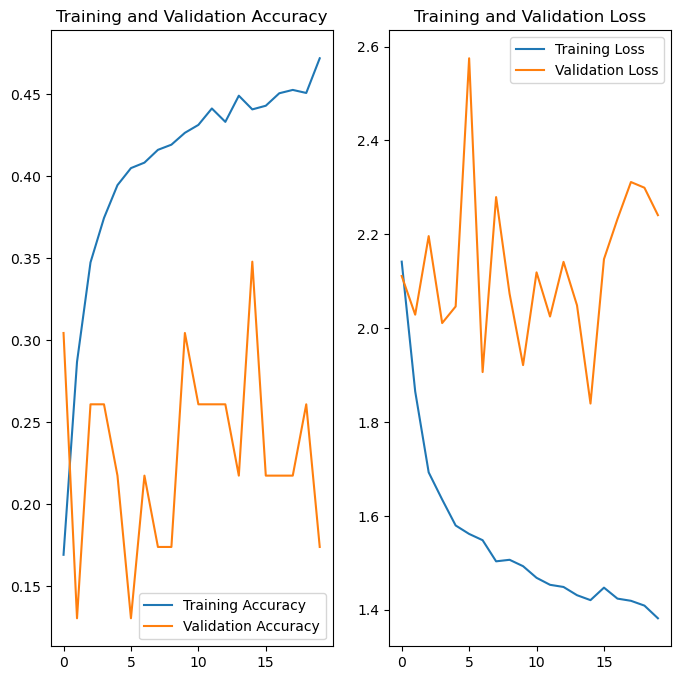

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.5. Performance on the modified model

In [ ]:
loss, accuracy = model_aug_drop.evaluate(cached_train_ds, verbose=1,)
loss_v, accuracy_v = model_aug_drop.evaluate(cached_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9551 - loss: 0.1086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3043 - loss: 7.0109
Accuracy:  0.9582715034484863
Validation Accuracy:  0.30434781312942505
Loss:  0.1063590720295906
Validation Loss 7.01094388961792


<div class="alert alert-block alert-info">
<h3>Observations:</h3>

1. The model with augmentation layers and dropouts does not perform better on the training data.
2. There is no improvement as compared to the previous model run.
3. The model still performs poorly during inference using the validation set.
4. There is some improvement, but the model is still **Overfitting**.

</div>

## 7. Class Distribution


Note:
* Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.
* Class imbalance can have a detrimental effect on the final model quality. 
* Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### 7.1. Display of the number of samples for each class/label

In [30]:
## Your code goes here.
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
Name: count, dtype: int64


2024-12-15 16:56:40.745616: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<div class="alert alert-block alert-info">
<h3>Observations:</h3>

1. A clear class imbalance is evident within the training data.
2. The class **seborrheic keratosis** comprises the least number of samples with only 58 samples.
3. **Pigmented benign keratosis** and **melanoma** significantly dominate other classes, representing 370 and 352 sample data, respectively.

</div>

## 8. Handling Class Imbalances

### 8.1. Use Augmentor to add more Samples


Note:
* We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin_Cancer_images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3170E0350>: 100%|██████████| 500/500 [00:01<00:00, 446.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin_Cancer_images/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x317129FD0>: 100%|██████████| 500/500 [00:01<00:00, 477.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin_Cancer_images/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x316FD1A30>: 100%|██████████| 500/500 [00:01<00:00, 443.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin_Cancer_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3170B4E90>: 100%|██████████| 500/500 [00:04<00:00, 104.45 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin_Cancer_images/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x315F4A5D0>: 100%|██████████| 500/500 [00:04<00:00, 107.30 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to Skin_Cancer_images/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x31B63D280>: 100%|██████████| 500/500 [00:01<00:00, 437.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin_Cancer_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x315E79880>: 100%|██████████| 500/500 [00:02<00:00, 223.31 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin_Cancer_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31C05B7A0>: 100%|██████████| 500/500 [00:01<00:00, 437.84 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin_Cancer_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x315E34B00>: 100%|██████████| 500/500 [00:01<00:00, 458.63 Samples/s]                  


Note: 
* Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
* Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### 8.2. Distribution of Augmented Data after adding new Images

Note:
* Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0000305.jpg_23b20dee-9d3a-4046-ac3b-e7e45ff47043.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_ba9610b9-779c-4154-b88e-613766327d5d.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0011121.jpg_fb7e9043-d77c-4d06-b55a-cf39962bc2b9.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0000166.jpg_e53838e2-f235-44d2-8a93-c9c8f49f4c96.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0010391.jpg_c1c4fa12-1d0d-4332-8346-c7885f43a1f1.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0009918.jpg_113da9ac-8abe-4899-98da-e7bb8d2f7e86.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0000547.jpg_145b76e5-1a1b-479a-8aeb-f972240047d1.jpg',
 'Skin_Cancer_images/Train/melanoma/output/melanoma_original_ISIC_0010414.jpg_c8845073-6100-4927-93d6-33344991c72d.jpg',
 'Skin_Cancer_images/Train/melan

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
Name: count, dtype: int64


In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

Label
melanoma                      1000
pigmented benign keratosis    1000
nevus                         1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: count, dtype: int64

<div class="alert alert-block alert-info">
<h3>Observations:</h3>

1. We can see 500 images added to all the classes to maintain some class balance.
2. This is done to rectify class imbalances present in the training dataset

</div>

## 9. Model Building and Training on Rectified Class Imbalance Data

#### 9.1. Create a training dataset

In [41]:
batch_size = 32
img_height = 180
img_width = 180

In [42]:
data_dir_train = pathlib.Path('./Skin_Cancer_images/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### 9.2. Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


### 9.3. Create your model (make sure to include normalization)

In [44]:
## your code goes here
num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

/Users/rajak/Workstation/Projects/myGitHub/LearnAIML/env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### 9.4. Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 9.5.  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
#epochs = 20
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - accuracy: 0.2239 - loss: 2.0100 - val_accuracy: 0.5042 - val_loss: 1.2962
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.5018 - loss: 1.3415 - val_accuracy: 0.6017 - val_loss: 1.0573
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.6161 - loss: 1.0365 - val_accuracy: 0.6809 - val_loss: 0.9292
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.7321 - loss: 0.7646 - val_accuracy: 0.7539 - val_loss: 0.6936
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.8058 - loss: 0.5639 - val_accuracy: 0.7855 - val_loss: 0.6198
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.8637 - loss: 0.4045 - val_accuracy: 0.7971 - val_loss: 0.6263
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.8796 - loss: 0.3396 - val_accuracy: 0.7810 - val_loss: 0.6767
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.8946 - loss: 0

### 9.6.  Visualize the model results

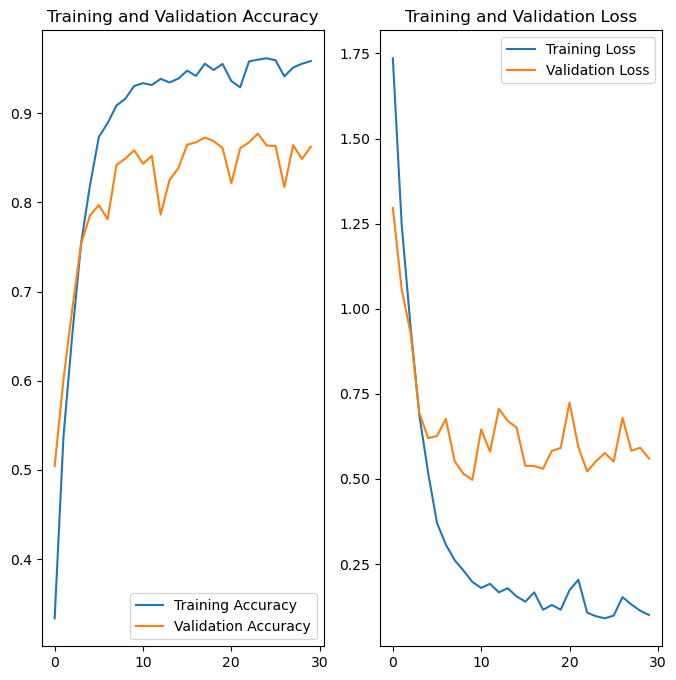

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
loss, accuracy = model3.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model3.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9542 - loss: 0.1081
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8657 - loss: 0.5210
Accuracy:  0.958185076713562
Validation Accuracy:  0.8624833226203918
Loss:  0.0995694175362587
Validation Loss 0.559733510017395


<div class="alert alert-block alert-info">
<h3>Observations:</h3>

1. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.
2. The final model attains an accuracy of 95% on the training set and approximately 86% on the validation set.
3. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

</div>

## 10. Final Conclusion

### 10.1. Model Evaluation and Conclusion

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Actual Class: melanoma
Predicted Class: melanoma


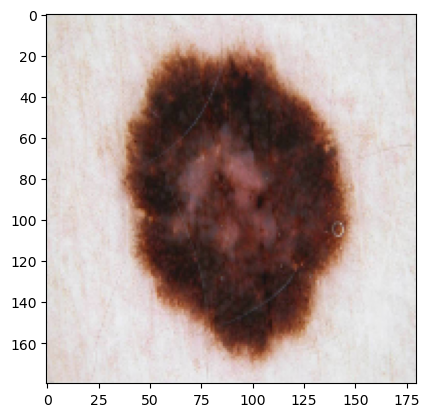

In [52]:
# Evaluating our model on melanoma class in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model3.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[3] +'\n'+ "Predicted Class: " + predicted_class)

<div class="alert alert-block alert-info">
<h3>Conclusion:</h3>

1. For the Final model evaluation on test data we can see it correctly predicted the class name
2. **Melanoma** has been correctly detected by our Final Model. 

</div>